**Hurrikarya baseline end-to-end complete** <br>
Initial code copied from Raoul Malm https://www.kaggle.com/raoulma <br>
Updated Sat, 08 April 2018
> Nuclei DSB 2018 TensorFlow U-Net Score 0.352 https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352

*Useful Knowledge Reference* <br>
U-Net Segmentation Approach to Cancer Diagnosis
written by Jonathan Mulholland and Aaron Sander, Booz Allen Hamilton
https://gist.github.com/ajsander/ea33b90cc6fcff2696cd3b350ed7f86c

The 2018 Data Science Bowl "Find the nuclei in divergent images to advance medical discovery" provides in its first stage a training and test data set consisting of 670 and 65 microscopic images of varying size showing ensembles of cells and their nuclei. For the training images the nuclei are segmented by humans such that we know their number and location within each image. The goal is to find the correct number and location of all nuclei shown in the test images. The performance of an algorithm is evaluated on the mean average precision at different intersection over union (IoU) thresholds, which will be referred to as the score in the following.

For the task we implement a deep neural network of the U-Net type consisting of several convolutional and max-pooling layers. The network is written in TensorFlow. Each model can be saved/loaded and the training process can be visualized with TensorBoard. The input of the network are images of shape (height, width, channels) while the output are corresponding binary masks of shape (height, width, 1).

Prior to training the network we resize, normalize and transform the images. We use 10% of the training data for validation. Furthermore, we implement data augmentation by making use of translations, rotations, horizontal/vertical flipping and zoom. Choosing an image size of 384x384 pixels the network requires roughly 30 training epochs before the training seems to converge. The network achieves a score of 0.56/0.352 on the validation/test set. A major reason for the score discrepancy can be explained by overlapping/touching nuclei that are identified as a single nucleous by the current implementation. Furthermore, we have not tuned the hyperparameters, so there is still a lot of room for improvement.

Being constrained on kaggel hardware and running time, we can choose an image size of 256x256 pixels and train for 4 epochs, which takes roughly 40 minutes. The network can achieve a score of 0.45 on the validation set.

Outline:

    0. Modules and global settings
    1. Load images
    2. Analyse data
    3. Manipulate data
    4. Score Metric
    5. Implement the Neural Network class
    6. Train the Neural Network
    7. Validate the Neural Network
    8. Make Test Prediction
    9. Submit

Reference:  [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

Install scikit-image package

### 1. Modules and global settings

### Folder Structure
The CW_DIR variable loads the current work directory, after that the TRAIN_DIR and the TEST_DIR we hard coded so you have to make sure these matches your directory structure.

In [8]:
# Import necessary modules and set global constants and variables. 

import tensorflow as tf            
import pandas as pd                 
import numpy as np                                       
import sklearn.model_selection     # For using KFold
import keras.preprocessing.image   # For using image generation
import datetime                    # To measure running time 
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline                  

# Global constants.
# We commented out to set the default model output as 512,512 (Hurrikarya)
#IMG_WIDTH = 256       # Default image width
#IMG_HEIGHT = 256      # Default image height
IMG_WIDTH = 512       # Default image width
IMG_HEIGHT = 512      # Default image height
IMG_CHANNELS = 3      # Default number of channels
CW_DIR = os.getcwd()  

# Folder location -- Hurrikarya, please ensure these folders are saved in this structure
TRAIN_DIR = os.path.join(os.path.dirname(CW_DIR), 'input', 'stage1_train')
TEST_DIR = os.path.join(os.path.dirname(CW_DIR), 'input', 'stage1_test')

IMG_TYPE = '.png'         # Image type
IMG_DIR_NAME = 'images'   # Folder name including the image
MASK_DIR_NAME = 'masks'   # Folder name including the masks
LOGS_DIR_NAME = 'logs'    # Folder name for TensorBoard summaries 
SAVES_DIR_NAME = 'saves'  # Folder name for storing network parameters
SEED = 123                # Random seed for splitting train/validation sets
    
# Global variables.
min_object_size = 1       # Minimal nucleous size in pixels
x_train = []
y_train = []
x_test = []
y_test_pred_proba = {}
y_test_pred = {}

# Display working/train/test directories.
print('CW_DIR = {}'.format(CW_DIR))
print('TRAIN_DIR = {}'.format(TRAIN_DIR))
print('TEST_DIR = {}'.format(TEST_DIR))

CW_DIR = /Users/mash/Documents/Code/kaggle
TRAIN_DIR = /Users/mash/Documents/Code/input/stage1_train
TEST_DIR = /Users/mash/Documents/Code/input/stage1_test


In [2]:
# Check you are using GPU

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5869118681590075948]

### 2. Analyse the data

In [9]:
# Collection of methods for data operations. Implemented are functions to read  
# images/masks from files and to read basic properties of the train/test data sets.

def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img

def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask 

def read_train_data_properties(train_dir, img_dir_name, mask_dir_name):
    """Read basic properties of training images and masks"""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(train_dir))[1]):

        img_dir = os.path.join(train_dir, dir_name, img_dir_name)
        mask_dir = os.path.join(train_dir, dir_name, mask_dir_name) 
        num_masks = len(next(os.walk(mask_dir))[2])
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], num_masks,
                    img_path, mask_dir])

    train_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                            'img_ratio', 'num_channels', 
                                            'num_masks', 'image_path', 'mask_dir'])
    return train_df

def read_test_data_properties(test_dir, img_dir_name):
    """Read basic properties of test images."""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(test_dir))[1]):

        img_dir = os.path.join(test_dir, dir_name, img_dir_name)
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], img_path])

    test_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                           'img_ratio', 'num_channels', 'image_path'])
    return test_df

def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

def load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    x_train, y_train, x_test = [],[],[]

    # Read and resize train images/masks. 
    print('Loading and resizing train images and masks ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(train_df['image_path']), total=len(train_df)):
        img = read_image(train_df['image_path'].loc[i], target_size=image_size)
        mask = read_mask(train_df['mask_dir'].loc[i], target_size=image_size)
        x_train.append(img)
        y_train.append(mask)

    # Read and resize test images. 
    print('Loading and resizing test images ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(test_df['image_path']), total=len(test_df)):
        img = read_image(test_df['image_path'].loc[i], target_size=image_size)
        x_test.append(img)

    # Transform lists into 4-dim numpy arrays.
    x_train = np.array(x_train)
    y_train = np.expand_dims(np.array(y_train), axis=4)
    x_test = np.array(x_test)

    print('x_train.shape: {} of dtype {}'.format(x_train.shape, x_train.dtype))
    print('y_train.shape: {} of dtype {}'.format(y_train.shape, x_train.dtype))
    print('x_test.shape: {} of dtype {}'.format(x_test.shape, x_test.dtype))
    
    return x_train, y_train, x_test
    

In [10]:
# Basic properties of images/masks. 
train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)
test_df = read_test_data_properties(TEST_DIR, IMG_DIR_NAME)
print('train_df:')
print(train_df.describe())
print('')
print('test_df:')
print(test_df.describe())

train_df:
        img_height    img_width   img_ratio  num_channels   num_masks
count   670.000000   670.000000  670.000000         670.0  670.000000
mean    333.991045   378.500000    0.921008           3.0   43.971642
std     149.474845   204.838693    0.114294           0.0   47.962530
min     256.000000   256.000000    0.474057           3.0    1.000000
25%     256.000000   256.000000    0.800000           3.0   15.250000
50%     256.000000   320.000000    1.000000           3.0   27.000000
75%     360.000000   360.000000    1.000000           3.0   54.000000
max    1040.000000  1388.000000    1.000000           3.0  375.000000

test_df:
       img_height   img_width  img_ratio  num_channels
count   65.000000   65.000000  65.000000          65.0
mean   402.676923  393.184615   1.186171           3.0
std    129.082956  189.813386   0.631035           0.0
min    256.000000  161.000000   0.747126           3.0
25%    256.000000  256.000000   0.800000           3.0
50%    512.000000  2

In [11]:
# Counting unique image shapes.
df = pd.DataFrame([[x] for x in zip(train_df['img_height'], train_df['img_width'])])
df[0].value_counts()

(256, 256)      334
(256, 320)      112
(520, 696)       92
(360, 360)       91
(1024, 1024)     16
(512, 640)       13
(603, 1272)       6
(260, 347)        5
(1040, 1388)      1
Name: 0, dtype: int64

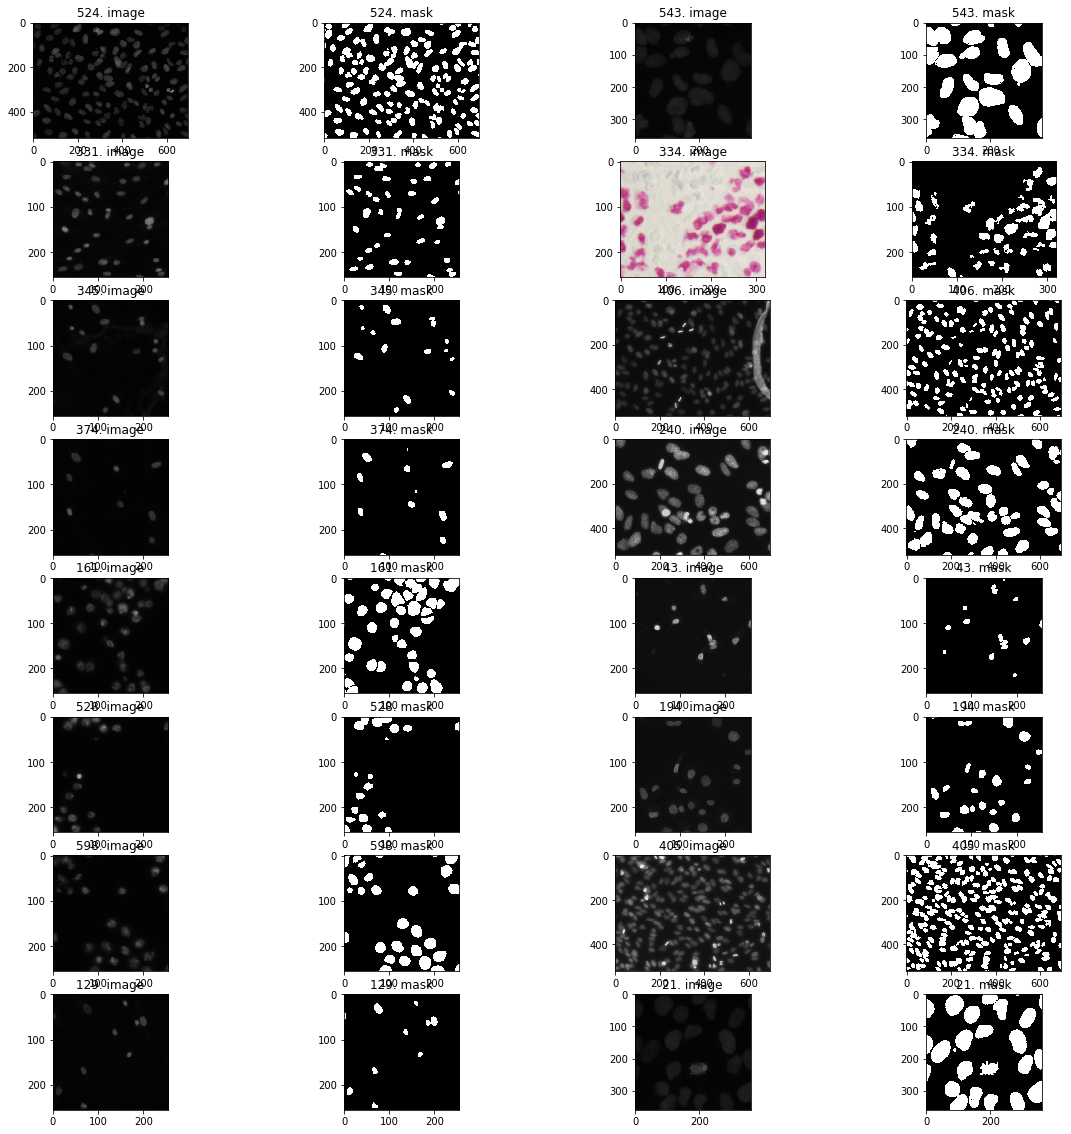

In [12]:
# Overview of train images/masks. There is a lot of variation concerning
# the form/size/number of nuclei and the darkness/lightness/colorfulness of 
# the images. 
fig, axs = plt.subplots(8,4,figsize=(20,20))
for i in range(8):
    for j in range(2):
        n = np.random.randint(0,len(train_df))
        axs[i,j*2].imshow(read_image(train_df['image_path'].loc[n]))
        axs[i,j*2].set_title('{}. image'.format(n))
        axs[i,j*2+1].imshow(read_mask(train_df['mask_dir'].loc[n]), cmap='gray') 
        axs[i,j*2+1].set_title('{}. mask'.format(n))       

In [13]:
# Read images/masks from files and resize them. Each image and mask 
# is stored as a 3-dim array where the number of channels is 3 and 1, respectively.
x_train, y_train, x_test = load_raw_data()


Loading and resizing train images and masks ...


100%|██████████| 670/670 [00:53<00:00, 12.55it/s]

Loading and resizing test images ...



100%|██████████| 65/65 [00:00<00:00, 138.97it/s]


x_train.shape: (670, 512, 512, 3) of dtype uint8
y_train.shape: (670, 512, 512, 1) of dtype uint8
x_test.shape: (65, 512, 512, 3) of dtype uint8


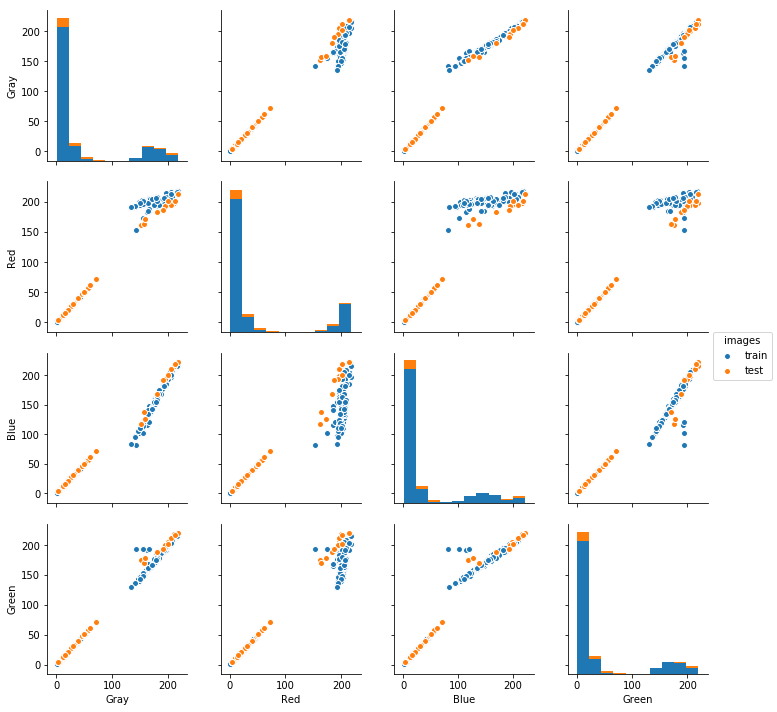

In [14]:
# Study the pixel intensity. On average the red, green and blue channels have similar
# intensities for all images. It should be noted that the background can be dark 
# (black) as  as well as light (white). 
def img_intensity_pairplot(x):
    """Plot intensity distributions of color channels."""
    df = pd.DataFrame()
    df['Gray'] = np.mean(x[:,:,:,:], axis=(1,2,3))
    if x.shape[3]==3:
        df['Red'] = np.mean(x[:,:,:,0], axis=(1,2))
        df['Blue'] = np.mean(x[:,:,:,1], axis=(1,2))
        df['Green'] = np.mean(x[:,:,:,2], axis=(1,2))
    return df

color_df = img_intensity_pairplot(np.concatenate([x_train, x_test]))
color_df['images'] = ['train']*len(x_train) + ['test']*len(x_test)
sns.pairplot(color_df, hue = 'images');

### 3. Manipulate data

In [15]:
# Collection of methods for basic data manipulation like normalizing, inverting, 
# color transformation and generating new images/masks

def normalize_imgs(data):
    """Normalize images."""
    return normalize(data, type_=1)

def normalize_masks(data):
    """Normalize masks."""
    return normalize(data, type_=1)
    
def normalize(data, type_=1): 
    """Normalize data."""
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32) / data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        div[div < 0.01*data.mean()] = 1. # protect against too small pixel intensities
        data = data.astype(np.float32)/div
    if type_==2:
        # Standardisation of each image 
        data = data.astype(np.float32) / data.max() 
        mean = data.mean(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        std = data.std(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        data = (data-mean)/std

    return data

def trsf_proba_to_binary(y_data):
    """Transform propabilities into binary values 0 or 1."""  
    return np.greater(y_data,.5).astype(np.uint8)

def invert_imgs(imgs, cutoff=.5):
    '''Invert image if mean value is greater than cutoff.'''
    imgs = np.array(list(map(lambda x: 1.-x if np.mean(x)>cutoff else x, imgs)))
    return normalize_imgs(imgs)

def imgs_to_grayscale(imgs):
    '''Transform RGB images into grayscale spectrum.''' 
    if imgs.shape[3]==3:
        imgs = normalize_imgs(np.expand_dims(np.mean(imgs, axis=3), axis=3))
    return imgs

def generate_images(imgs, seed=None):
    """Generate new images."""
    # Transformations.
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 90., width_shift_range = 0.02 , height_shift_range = 0.02,
        zoom_range = 0.10, horizontal_flip=True, vertical_flip=True)
    
    # Generate new set of images
    imgs = image_generator.flow(imgs, np.zeros(len(imgs)), batch_size=len(imgs),
                                shuffle = False, seed=seed).next()    
    return imgs[0]

def generate_images_and_masks(imgs, masks):
    """Generate new images and masks."""
    seed = np.random.randint(10000) 
    imgs = generate_images(imgs, seed=seed)
    masks = trsf_proba_to_binary(generate_images(masks, seed=seed))
    return imgs, masks

def preprocess_raw_data(x_train, y_train, x_test, grayscale=False, invert=False):
    """Preprocessing of images and masks."""
    # Normalize images and masks
    x_train = normalize_imgs(x_train)
    y_train = trsf_proba_to_binary(normalize_masks(y_train))
    x_test = normalize_imgs(x_test)
    print('Images normalized.')
 
    if grayscale:
        # Remove color and transform images into grayscale spectrum.
        x_train = imgs_to_grayscale(x_train)
        x_test = imgs_to_grayscale(x_test)
        print('Images transformed into grayscale spectrum.')

    if invert:
        # Invert images, such that each image has a dark background.
        x_train = invert_imgs(x_train)
        x_test = invert_imgs(x_test)
        print('Images inverted to remove light backgrounds.')

    return x_train, y_train, x_test
    

In [16]:
# Normalize all images and masks. There is the possibility to transform images 
# into the grayscale sepctrum and to invert images which have a very 
# light background.
x_train, y_train, x_test = preprocess_raw_data(x_train, y_train, x_test, invert=True)

Images normalized.
Images inverted to remove light backgrounds.


In [17]:
# Analyze nuclei sizes.
def get_nuclei_sizes():
    nuclei_sizes = []
    mask_idx = []
    for i in range(len(y_train)):
        mask = y_train[i].reshape(y_train.shape[1], y_train.shape[2])
        lab_mask = skimage.morphology.label(mask > .5)
        (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
        nuclei_sizes.extend(mask_sizes[1:])
        mask_idx.extend([i]*len(mask_sizes[1:]))
    return mask_idx, nuclei_sizes

mask_idx, nuclei_sizes = get_nuclei_sizes()
nuclei_sizes_df = pd.DataFrame()   
nuclei_sizes_df['mask_index'] = mask_idx
nuclei_sizes_df['nucleous_size'] = nuclei_sizes

print(nuclei_sizes_df.describe())
nuclei_sizes_df.sort_values(by='nucleous_size', ascending=True).head(10)

         mask_index  nucleous_size
count  24046.000000   24046.000000
mean     340.435083    1016.638693
std      187.633353    1663.208040
min        0.000000       1.000000
25%      175.000000     300.000000
50%      344.000000     516.000000
75%      500.000000    1072.000000
max      669.000000   48270.000000


,mask_index,nucleous_size
22214,617,1
3936,126,1
5453,156,1
11567,332,4
17299,474,4
4525,141,6
4695,141,6
5230,153,7
5251,153,7
15574,428,7


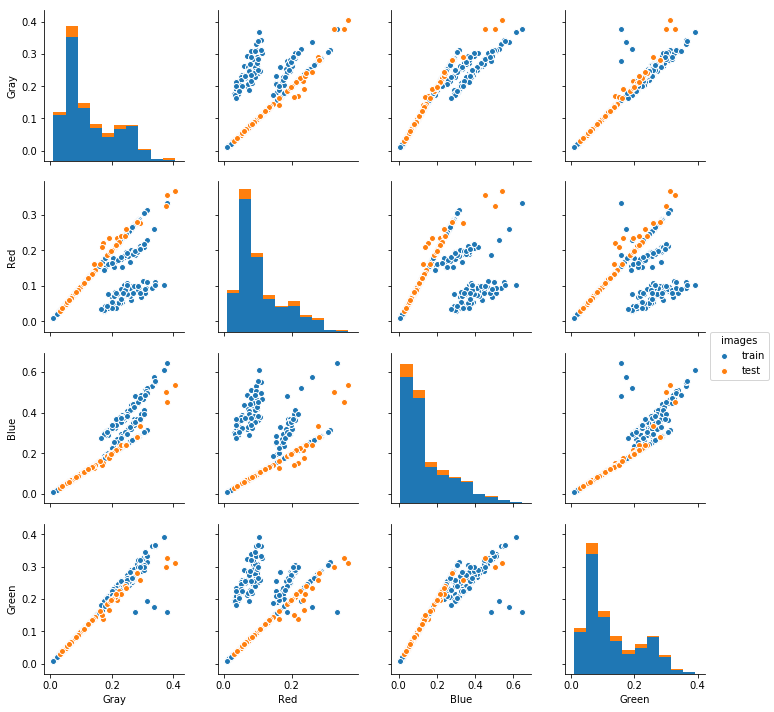

In [18]:
color_df = img_intensity_pairplot(np.concatenate([x_train, x_test]))
color_df['images'] = ['train']*len(x_train) + ['test']*len(x_test)
sns.pairplot(color_df, hue = 'images');

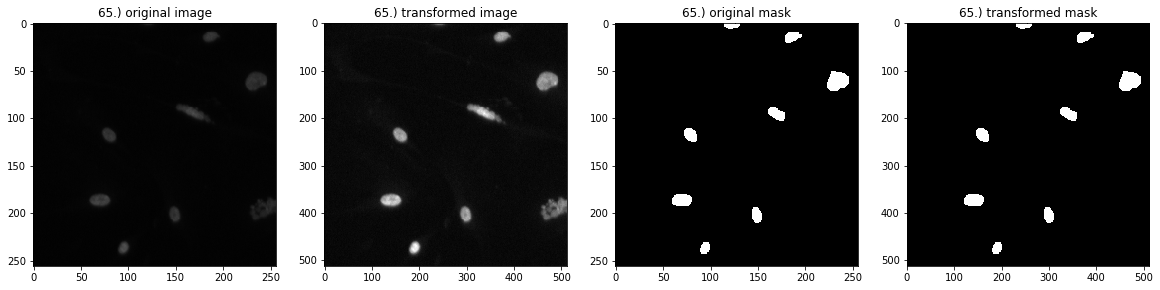

In [19]:
# Check the image transformation procedure (resizing, normalizing, inverting) 
# by looking at a sample. 
def img_comparison_plot(n):
    """Plot the original and transformed images/masks."""
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    axs[0].imshow(read_image(train_df['image_path'].loc[n]))
    axs[0].set_title('{}.) original image'.format(n))
    img, img_type = imshow_args(x_train[n])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}.) transformed image'.format(n))
    axs[2].imshow(read_mask(train_df['mask_dir'].loc[n]), cm.gray) 
    axs[2].set_title('{}.) original mask'.format(n))
    axs[3].imshow(y_train[n,:,:,0], cm.gray)
    axs[3].set_title('{}.) transformed mask'.format(n));

n = np.random.randint(0, len(x_train)) #617
img_comparison_plot(n)

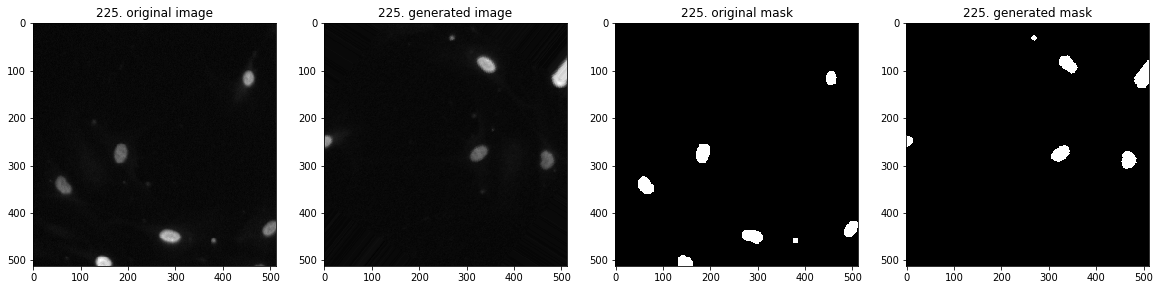

In [20]:
# Generate new images/masks via transformations applied on the original 
# images/maks. Data augmentations can be used for regularization.
def plot_generated_image_mask(n):
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    img_new, mask_new = generate_images_and_masks(x_train[n:n+1], y_train[n:n+1])
    img, img_type = imshow_args(x_train[n])
    axs[0].imshow(img, img_type)
    axs[0].set_title('{}. original image'.format(n))
    img, img_type = imshow_args(img_new[0])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}. generated image'.format(n))
    axs[2].imshow(y_train[n,:,:,0], cmap='gray')
    axs[2].set_title('{}. original mask'.format(n))
    axs[3].imshow(mask_new[0,:,:,0], cmap='gray')
    axs[3].set_title('{}. generated mask'.format(n));

n = np.random.randint(len(x_train)) #166
plot_generated_image_mask(n)

### 4. Score metric

In [21]:
""" Collection of methods to compute the score.

1. We start with a true and predicted mask, corresponding to one train image.

2. The true mask is segmented into different objects. Here lies a main source 
of error. Overlapping or touching nuclei are not separated but are labeled as 
one object. This means that the target mask can contain less objects than 
those that have been originally identified by humans.

3. In the same manner the predicted mask is segmented into different objects.

4. We compute all intersections between the objects of the true and predicted 
masks. Starting with the largest intersection area we assign true objects to 
predicted ones, until there are no true/pred objects left that overlap. 
We then compute for each true/pred object pair their corresponding intersection 
over union (iou) ratio. 

5. Given some threshold t we count the object pairs that have an iou > t, which
yields the number of true positives: tp(t). True objects that have no partner are 
counted as false positives: fp(t). Likewise, predicted objects without a counterpart
a counted as false negatives: fn(t).

6. Now, we compute the precision tp(t)/(tp(t)+fp(t)+fn(t)) for t=0.5,0.55,0.60,...,0.95
and take the mean value as the final precision (score).
"""

def get_labeled_mask(mask, cutoff=.5):
    """Object segmentation by labeling the mask."""
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    lab_mask = skimage.morphology.label(mask > cutoff) 
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
    
    return lab_mask  

def get_iou(y_true_labeled, y_pred_labeled):
    """Compute non-zero intersections over unions."""
    # Array of different objects and occupied area.
    (true_labels, true_areas) = np.unique(y_true_labeled, return_counts=True)
    (pred_labels, pred_areas) = np.unique(y_pred_labeled, return_counts=True)

    # Number of different labels.
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Each mask has at least one identified object.
    if (n_true_labels > 1) and (n_pred_labels > 1):
        
        # Compute all intersections between the objects.
        all_intersections = np.zeros((n_true_labels, n_pred_labels))
        for i in range(y_true_labeled.shape[0]):
            for j in range(y_true_labeled.shape[1]):
                m = y_true_labeled[i,j]
                n = y_pred_labeled[i,j]
                all_intersections[m,n] += 1 

        # Assign predicted to true background.
        assigned = [[0,0]]
        tmp = all_intersections.copy()
        tmp[0,:] = -1
        tmp[:,0] = -1

        # Assign predicted to true objects if they have any overlap.
        for i in range(1, np.min([n_true_labels, n_pred_labels])):
            mn = list(np.unravel_index(np.argmax(tmp), (n_true_labels, n_pred_labels)))
            if all_intersections[mn[0], mn[1]] > 0:
                assigned.append(mn)
            tmp[mn[0],:] = -1
            tmp[:,mn[1]] = -1
        assigned = np.array(assigned)

        # Intersections over unions.
        intersection = np.array([all_intersections[m,n] for m,n in assigned])
        union = np.array([(true_areas[m] + pred_areas[n] - all_intersections[m,n]) 
                           for m,n in assigned])
        iou = intersection / union

        # Remove background.
        iou = iou[1:]
        assigned = assigned[1:]
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]

        # Labels that are not assigned.
        true_not_assigned = np.setdiff1d(true_labels, assigned[:,0])
        pred_not_assigned = np.setdiff1d(pred_labels, assigned[:,1])
        
    else:
        # in case that no object is identified in one of the masks
        iou = np.array([])
        assigned = np.array([])
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]
        true_not_assigned = true_labels
        pred_not_assigned = pred_labels
        
    # Returning parameters.
    params = {'iou': iou, 'assigned': assigned, 'true_not_assigned': true_not_assigned,
             'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
             'pred_labels': pred_labels}
    return params

def get_score_summary(y_true, y_pred):
    """Compute the score for a single sample including a detailed summary."""
    
    y_true_labeled = get_labeled_mask(y_true)  
    y_pred_labeled = get_labeled_mask(y_pred)  
    
    params = get_iou(y_true_labeled, y_pred_labeled)
    iou = params['iou']
    assigned = params['assigned']
    true_not_assigned = params['true_not_assigned']
    pred_not_assigned = params['pred_not_assigned']
    true_labels = params['true_labels']
    pred_labels = params['pred_labels']
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    summary = []
    for i,threshold in enumerate(np.arange(0.5, 1.0, 0.05)):
        tp = np.sum(iou > threshold)
        fn = n_true_labels - tp
        fp = n_pred_labels - tp
        if (tp+fp+fn)>0: 
            prec = tp/(tp+fp+fn)
        else: 
            prec = 0
        summary.append([threshold, prec, tp, fp, fn])

    summary = np.array(summary)
    score = np.mean(summary[:,1]) # Final score.
    params_dict = {'summary': summary, 'iou': iou, 'assigned': assigned, 
                   'true_not_assigned': true_not_assigned, 
                   'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
                   'pred_labels': pred_labels, 'y_true_labeled': y_true_labeled,
                   'y_pred_labeled': y_pred_labeled}
    
    return score, params_dict

def get_score(y_true, y_pred):
    """Compute the score for a batch of samples."""
    scores = []
    for i in range(len(y_true)):
        score,_ = get_score_summary(y_true[i], y_pred[i])
        scores.append(score)
    return np.array(scores)

def plot_score_summary(y_true, y_pred):
    """Plot score summary for a single sample."""
    # Compute score and assign parameters.
    score, params_dict = get_score_summary(y_true, y_pred)
    
    assigned = params_dict['assigned']
    true_not_assigned = params_dict['true_not_assigned']
    pred_not_assigned = params_dict['pred_not_assigned']
    true_labels = params_dict['true_labels']
    pred_labels = params_dict['pred_labels']
    y_true_labeled = params_dict['y_true_labeled']
    y_pred_labeled = params_dict['y_pred_labeled']
    summary = params_dict['summary']

    n_assigned = len(assigned)
    n_true_not_assigned = len(true_not_assigned)
    n_pred_not_assigned = len(pred_not_assigned)
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Summary dataframe.
    summary_df = pd.DataFrame(summary,columns=['threshold','precision','tp','fp','fn'])
    print('Final score:', score)
    print(summary_df)

    # Plots.
    fig, axs = plt.subplots(2,3,figsize=(20,13))

    # True mask with true objects.
    img = y_true
    axs[0,0].imshow(img, cmap=cm.gray)
    axs[0,0].set_title('{}.) true mask: {} true objects'.format(n,train_df['num_masks'][n]))
    
    # True mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_true_labeled > 0.5] = 255
    img, img_type = imshow_args(y_true_labeled)
    axs[0,1].imshow(img, img_type)
    axs[0,1].set_title('{}.) true mask: {} objects identified'.format(n, n_true_labels))
    
    # Predicted mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_pred_labeled > 0.5] = 255
    img, img_type = imshow_args(y_pred_labeled)
    axs[0,2].imshow(img, img_type)
    axs[0,2].set_title('{}.) predicted mask: {} objects identified'.format(
        n, n_pred_labels))

    # Prediction overlap with true mask.
    img = np.zeros(y_true.shape)
    img[y_true > 0.5] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,0].set_title('{}.) {} pred. overlaps (white) with true objects (gray)'.format(
        n,len(assigned)))
    axs[1,0].imshow(img, cmap='gray', norm=None)

    # Intersection over union.
    img = np.zeros(y_true.shape)
    img[(y_pred_labeled > 0) & (y_pred_labeled < 100)] = 100
    img[(y_true_labeled > 0) & (y_true_labeled < 100)] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,1].set_title('{}.) {} intersections (white) over unions (gray)'.format(
        n, n_assigned))
    axs[1,1].imshow(img, cmap='gray');

    # False positives and false negatives.
    img = np.zeros(y_true.shape)
    for i in pred_not_assigned: img[(y_pred_labeled == i)] = 255
    for i in true_not_assigned: img[(y_true_labeled == i)] = 100
    axs[1,2].set_title('{}.) no threshold: {} fp (white), {} fn (gray)'.format(
        n, n_pred_not_assigned, n_true_not_assigned))
    axs[1,2].imshow(img, cmap='gray');

Final score: 0.0624242424242
   threshold  precision   tp   fp   fn
0       0.50   0.333333  3.0  3.0  3.0
1       0.55   0.200000  2.0  4.0  4.0
2       0.60   0.090909  1.0  5.0  5.0
3       0.65   0.000000  0.0  6.0  6.0
4       0.70   0.000000  0.0  6.0  6.0
5       0.75   0.000000  0.0  6.0  6.0
6       0.80   0.000000  0.0  6.0  6.0
7       0.85   0.000000  0.0  6.0  6.0
8       0.90   0.000000  0.0  6.0  6.0
9       0.95   0.000000  0.0  6.0  6.0


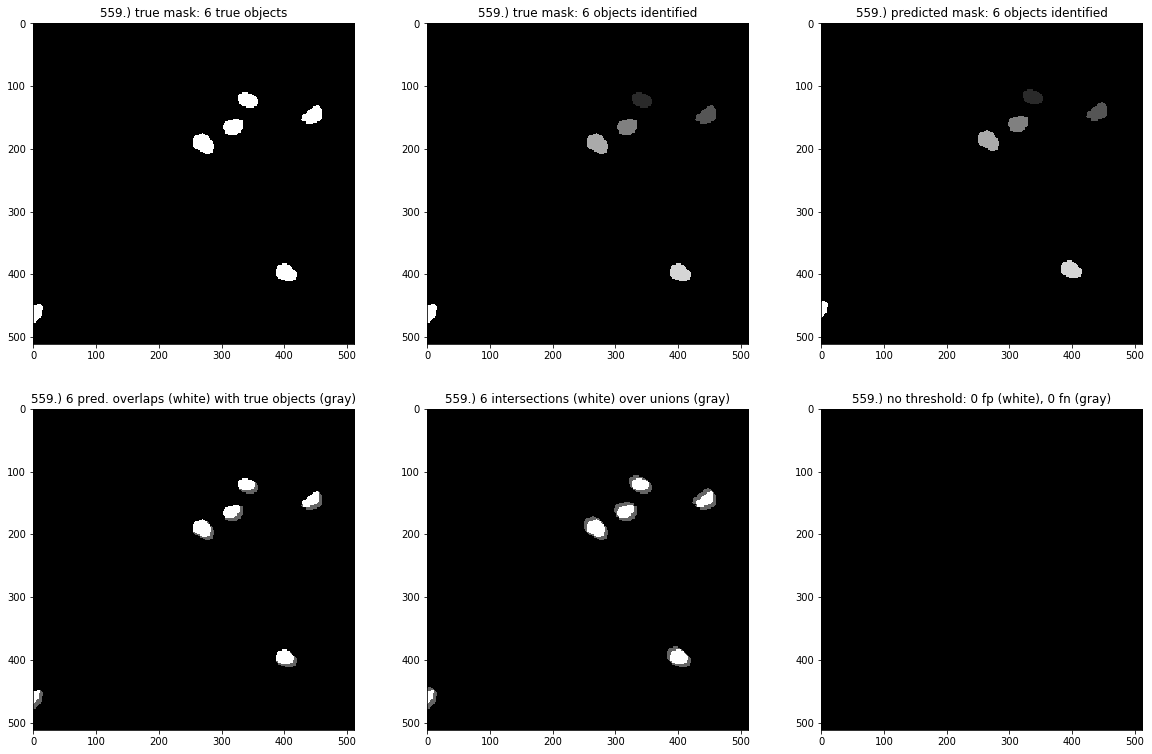

In [22]:
# Check the score metric for one sample. The predicted mask is simulated
# and can be modified in order to check the correct implementation of
# the score metric.
n = np.random.randint(len(x_train)) #166
true_mask = y_train[n,:,:,0].copy()
lab_true_mask = get_labeled_mask(true_mask)
pred_mask = true_mask.copy() # Create predicted mask from true mask.
true_mask[lab_true_mask == 7] = 0 # Remove one object => false postive
pred_mask[lab_true_mask == 10] = 0 # Remove one object => false negative
offset = 5  # Offset.
pred_mask = pred_mask[offset:, offset:]
pred_mask = np.pad(pred_mask, ((0, offset), (0, offset)), mode="constant")
plot_score_summary(true_mask, pred_mask) 


In [23]:
# Study how many objects in the masks can be identified. This is a limiting factor
# for the overall performance.
min_pixels_per_object = 1
summary = []
for n in range(len(y_train)):
    img = y_train[n,:,:,0]
    lab_img=get_labeled_mask(img)
    img_labels, img_area = np.unique(lab_img, return_counts=True)
    img_labels = img_labels[img_area>=min_pixels_per_object]
    img_area = img_area[img_area>=min_pixels_per_object]
    n_true_labels = train_df['num_masks'][n]
    n_ident_labels = len(img_labels)
    diff = np.abs(n_ident_labels-n_true_labels)
    summary.append([n_true_labels, n_ident_labels, diff])

sum_df = pd.DataFrame(summary, columns=(['true_objects', 'identified_objects', 'subtraction']))
sum_df.describe()

,true_objects,identified_objects,subtraction
count,670.000000,670.000000,670.000000
mean,43.971642,36.889552,7.520896
std,47.962530,36.913947,14.521939
min,1.000000,2.000000,0.000000
25%,15.250000,14.250000,1.000000
50%,27.000000,24.000000,2.000000
75%,54.000000,44.000000,8.000000
max,375.000000,340.000000,155.000000


### 5. Implement the Neural Network Class

Entire UNet neural network class is just set up in this block below. The next section calls it to train the UNet neural network. 

In [33]:
class NeuralNetwork():
    """ Implements a neural network.
        
        TensorFlow is used to implement the U-Net, which consists of convolutional
        and max pooling layers. Input and output shapes coincide. Methods are
        implemented to train the model, to save/load the complete session and to 
        attach summaries for visualization with TensorBoard. 
    """

    def __init__(self, nn_name='tmp', nn_type='UNet', log_step=0.2, keep_prob=0.33, 
                 mb_size=300, input_shape=[IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS], 
                 output_shape=[IMG_HEIGHT,IMG_WIDTH,1]):
        """Instance constructor."""
        
        # Tunable hyperparameters for training.
        self.mb_size = mb_size       # Mini batch size
        self.keep_prob = keep_prob   # Keeping probability with dropout regularization 
        self.learn_rate_step = 3     # Step size in terms of epochs
        self.learn_rate_alpha = 0.25 # Reduction of learn rate for each step 
        self.learn_rate_0 = 0.001    # Starting learning rate 
        self.dropout_proba = 0.1     # == 1-keep_probability
        
        # Set helper variables.
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.nn_type = nn_type                # Type of neural network
        self.nn_name = nn_name                # Name of neural network
        self.params = {}                      # For storing parameters
        self.learn_rate_pos = 0                
        self.learn_rate = self.learn_rate_0
        self.index_in_epoch = 0 
        self.epoch = 0. 
        self.log_step = log_step              # Log results in terms of epochs
        self.n_log_step = 0                   # Count number of mini batches  
        self.train_on_augmented_data = False  # True = use augmented data 
        self.use_tb_summary = False           # True = use TensorBoard summaries
        self.use_tf_saver = False             # True = save the session
        
        # Parameters that should be stored.
        self.params['train_loss']=[]
        self.params['valid_loss']=[]
        self.params['train_score']=[]
        self.params['valid_score']=[]
        
    def get_learn_rate(self):
        """Compute the current learning rate."""
        if False:
            # Fixed learnrate
            learn_rate = self.learn_rate_0
        else:
            # Decreasing learnrate each step by factor 1-alpha
            learn_rate = self.learn_rate_0*(1.-self.learn_rate_alpha)**self.learn_rate_pos
        return learn_rate

    def next_mini_batch(self):
        """Get the next mini batch."""
        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size           
        self.epoch += self.mb_size/len(self.x_train)
        
        # At the start of the epoch.
        if start == 0:
            np.random.shuffle(self.perm_array) # Shuffle permutation array.
   
        # In case the current index is larger than one epoch.
        if self.index_in_epoch > len(self.x_train):
            self.index_in_epoch = 0
            self.epoch -= self.mb_size/len(self.x_train) 
            return self.next_mini_batch() # Recursive use of function.
        
        end = self.index_in_epoch
        
        # Original data.
        x_tr = self.x_train[self.perm_array[start:end]]
        y_tr = self.y_train[self.perm_array[start:end]]
        
        # Use augmented data.
        if self.train_on_augmented_data:
            x_tr, y_tr = generate_images_and_masks(x_tr, y_tr)
            y_tr = trsf_proba_to_binary(y_tr)
        
        return x_tr, y_tr
 
    def weight_variable(self, shape, name=None):
        """ Weight initialization """
        #initializer = tf.truncated_normal(shape, stddev=0.1)
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        return tf.get_variable(name, shape=shape, initializer=initializer)

    def bias_variable(self, shape, name=None):
        """Bias initialization."""
        #initializer = tf.constant(0.1, shape=shape)  
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        return tf.get_variable(name, shape=shape, initializer=initializer)
     
    def conv2d(self, x, W, name=None):
        """ 2D convolution. """
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME', name=name)

    def max_pool_2x2(self, x, name=None):
        """ Max Pooling 2x2. """
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME',
                              name=name)
    
    def conv2d_transpose(self, x, filters, name=None):
        """ Transposed 2d convolution. """
        return tf.layers.conv2d_transpose(x, filters=filters, kernel_size=2, 
                                          strides=2, padding='SAME') 
    
    def leaky_relu(self, z, name=None):
        """Leaky ReLU."""
        return tf.maximum(0.01 * z, z, name=name)
    
    def activation(self, x, name=None):
        """ Activation function. """
        a = tf.nn.elu(x, name=name)
        #a = self.leaky_relu(x, name=name)
        #a = tf.nn.relu(x, name=name)
        return a 
    
    def loss_tensor(self):
        """Loss tensor."""
        if True:
            # Dice loss based on Jaccard dice score coefficent.
            axis=np.arange(1,len(self.output_shape)+1)
            offset = 1e-5
            corr = tf.reduce_sum(self.y_data_tf * self.y_pred_tf, axis=axis)
            l2_pred = tf.reduce_sum(tf.square(self.y_pred_tf), axis=axis)
            l2_true = tf.reduce_sum(tf.square(self.y_data_tf), axis=axis)
            dice_coeff = (2. * corr + 1e-5) / (l2_true + l2_pred + 1e-5)
            # Second version: 2-class variant of dice loss
            #corr_inv = tf.reduce_sum((1.-self.y_data_tf) * (1.-self.y_pred_tf), axis=axis)
            #l2_pred_inv = tf.reduce_sum(tf.square(1.-self.y_pred_tf), axis=axis)
            #l2_true_inv = tf.reduce_sum(tf.square(1.-self.y_data_tf), axis=axis)
            #dice_coeff = ((corr + offset) / (l2_true + l2_pred + offset) +
            #             (corr_inv + offset) / (l2_pred_inv + l2_true_inv + offset))
            loss = tf.subtract(1., tf.reduce_mean(dice_coeff))
        if False:
            # Sigmoid cross entropy. 
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.y_data_tf, logits=self.z_pred_tf))
        return loss 
    
    def optimizer_tensor(self):
        """Optimization tensor."""
        # Adam Optimizer (adaptive moment estimation). 
        optimizer = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
                    self.loss_tf, name='train_step_tf')
        return optimizer
   
    def batch_norm_layer(self, x, name=None):
        """Batch normalization layer."""
        if False:
            layer = tf.layers.batch_normalization(x, training=self.training_tf, 
                                                  momentum=0.9, name=name)
        else: 
            layer = x
        return layer
    
    def dropout_layer(self, x, name=None):
        """Dropout layer."""
        if False:
            layer = tf.layers.dropout(x, self.dropout_proba, training=self.training_tf,
                                     name=name)
        else:
            layer = x
        return layer

    def num_of_weights(self,tensors):
        """Compute the number of weights."""
        sum_=0
        for i in range(len(tensors)):
            m = 1
            for j in range(len(tensors[i].shape)):
                m *= int(tensors[i].shape[j])
            sum_+=m
        return sum_

    def build_UNet_graph(self):
        """ Create the UNet graph in TensorFlow. """
        # 1. unit 
        with tf.name_scope('1.unit'):
            W1_1 = self.weight_variable([3,3,self.input_shape[2],16], 'W1_1')
            b1_1 = self.bias_variable([16], 'b1_1')
            Z1 = self.conv2d(self.x_data_tf, W1_1, 'Z1') + b1_1
            A1 = self.activation(self.batch_norm_layer(Z1)) # (.,128,128,16)
            A1_drop = self.dropout_layer(A1)
            W1_2 = self.weight_variable([3,3,16,16], 'W1_2')
            b1_2 = self.bias_variable([16], 'b1_2')
            Z2 = self.conv2d(A1_drop, W1_2, 'Z2') + b1_2
            A2 = self.activation(self.batch_norm_layer(Z2)) # (.,128,128,16)
            P1 = self.max_pool_2x2(A2, 'P1') # (.,64,64,16)
        # 2. unit 
        with tf.name_scope('2.unit'):
            W2_1 = self.weight_variable([3,3,16,32], "W2_1")
            b2_1 = self.bias_variable([32], 'b2_1')
            Z3 = self.conv2d(P1, W2_1) + b2_1
            A3 = self.activation(self.batch_norm_layer(Z3)) # (.,64,64,32)
            A3_drop = self.dropout_layer(A3)
            W2_2 = self.weight_variable([3,3,32,32], "W2_2")
            b2_2 = self.bias_variable([32], 'b2_2')
            Z4 = self.conv2d(A3_drop, W2_2) + b2_2
            A4 = self.activation(self.batch_norm_layer(Z4)) # (.,64,64,32)
            P2 = self.max_pool_2x2(A4) # (.,32,32,32)
        # 3. unit
        with tf.name_scope('3.unit'):
            W3_1 = self.weight_variable([3,3,32,64], "W3_1")
            b3_1 = self.bias_variable([64], 'b3_1')
            Z5 = self.conv2d(P2, W3_1) + b3_1
            A5 = self.activation(self.batch_norm_layer(Z5)) # (.,32,32,64)
            A5_drop = self.dropout_layer(A5)
            W3_2 = self.weight_variable([3,3,64,64], "W3_2")
            b3_2 = self.bias_variable([64], 'b3_2')
            Z6 = self.conv2d(A5_drop, W3_2) + b3_2
            A6 = self.activation(self.batch_norm_layer(Z6)) # (.,32,32,64)
            P3 = self.max_pool_2x2(A6) # (.,16,16,64)
        # 4. unit
        with tf.name_scope('4.unit'):
            W4_1 = self.weight_variable([3,3,64,128], "W4_1")
            b4_1 = self.bias_variable([128], 'b4_1')
            Z7 = self.conv2d(P3, W4_1) + b4_1
            A7 = self.activation(self.batch_norm_layer(Z7)) # (.,16,16,128)
            A7_drop = self.dropout_layer(A7)
            W4_2 = self.weight_variable([3,3,128,128], "W4_2")
            b4_2 = self.bias_variable([128], 'b4_2')
            Z8 = self.conv2d(A7_drop, W4_2) + b4_2
            A8 = self.activation(self.batch_norm_layer(Z8)) # (.,16,16,128)
            P4 = self.max_pool_2x2(A8) # (.,8,8,128)
        # 5. unit 
        with tf.name_scope('5.unit'):
            W5_1 = self.weight_variable([3,3,128,256], "W5_1")
            b5_1 = self.bias_variable([256], 'b5_1')
            Z9 = self.conv2d(P4, W5_1) + b5_1
            A9 = self.activation(self.batch_norm_layer(Z9)) # (.,8,8,256)
            A9_drop = self.dropout_layer(A9)
            W5_2 = self.weight_variable([3,3,256,256], "W5_2")
            b5_2 = self.bias_variable([256], 'b5_2')
            Z10 = self.conv2d(A9_drop, W5_2) + b5_2
            A10 = self.activation(self.batch_norm_layer(Z10)) # (.,8,8,256)
            P5 = self.max_pool_2x2(A10) # (.,4,4,256)

        # 6. unit new
        with tf.name_scope('6.unit_new'):
            W6_1 = self.weight_variable([3,3,256,512], "W6_1")
            b6_1 = self.bias_variable([512], 'b6_1')
            Z11 = self.conv2d(P5, W6_1) + b6_1
            A11 = self.activation(self.batch_norm_layer(Z11)) # (.,8,8,512)
            A11_drop = self.dropout_layer(A11)
            W6_2 = self.weight_variable([3,3,512,512], "W6_2")
            b6_2 = self.bias_variable([512], 'b6_2')
            Z12 = self.conv2d(A11_drop, W6_2) + b6_2
            A12 = self.activation(self.batch_norm_layer(Z12)) # (.,8,8,512)
            
        
        # 7. unit new
        with tf.name_scope('7.unit_new'):
            W7_1 = self.weight_variable([3,3,512,256], "W7_1")
            b7_1 = self.bias_variable([256], 'b7_1')
            U1 = self.conv2d_transpose(A12, 256) # (.,16,16,256)
            U1 = tf.concat([U1, A10], 3) # (.,16,16,256)
            Z13 = self.conv2d(U1, W7_1) + b7_1
            A13 = self.activation(self.batch_norm_layer(Z13)) # (.,16,16,256)
            A13_drop = self.dropout_layer(A13)
            W7_2 = self.weight_variable([3,3,256,256], "W7_2")
            b7_2 = self.bias_variable([256], 'b7_2')
            Z14 = self.conv2d(A13_drop, W7_2) + b7_2
            A14 = self.activation(self.batch_norm_layer(Z14)) # (.,16,16,256)
            
        # 8. unit
        with tf.name_scope('8.unit_new'):
            W8_1 = self.weight_variable([3,3,256,128], "W8_1")
            b8_1 = self.bias_variable([128], 'b8_1')
            U2 = self.conv2d_transpose(A14, 128) # (.,16,16,128)
            U2 = tf.concat([U2, A8], 3) # (.,16,16,256)
            Z15 = self.conv2d(U2, W8_1) + b8_1
            A15 = self.activation(self.batch_norm_layer(Z15)) # (.,16,16,128)
            A15_drop = self.dropout_layer(A15)
            W8_2 = self.weight_variable([3,3,128,128], "W8_2")
            b8_2 = self.bias_variable([128], 'b8_2')
            Z16 = self.conv2d(A15_drop, W8_2) + b8_2
            A16 = self.activation(self.batch_norm_layer(Z16)) # (.,16,16,128)
        # 9. unit 
        with tf.name_scope('9.unit_new'):
            W9_1 = self.weight_variable([3,3,128,64], "W9_1")
            b9_1 = self.bias_variable([64], 'b9_1')
            U3 = self.conv2d_transpose(A16, 64) # (.,32,32,64)
            U3 = tf.concat([U3, A6],3) # (.,32,32,128)
            Z17 = self.conv2d(U3, W9_1) + b9_1
            A17 = self.activation(self.batch_norm_layer(Z17)) # (.,32,32,64)
            A17_drop = self.dropout_layer(A17)
            W9_2 = self.weight_variable([3,3,64,64], "W9_2")
            b9_2 = self.bias_variable([64], 'b9_2')
            Z18 = self.conv2d(A17_drop, W9_2) + b9_2
            A18 = self.activation(self.batch_norm_layer(Z18)) # (.,32,32,64)
        # 10. unit
        with tf.name_scope('10.unit_new'):
            W10_1 = self.weight_variable([3,3,64,32], "W10_1")
            b10_1 = self.bias_variable([32], 'b10_1')
            U4 = self.conv2d_transpose(A18, 32) # (.,64,64,32)
            U4 = tf.concat([U4, A4],3) # (.,64,64,64)
            Z19 = self.conv2d(U4, W10_1) + b10_1
            A19 = self.activation(self.batch_norm_layer(Z19)) # (.,64,64,32)
            A19_drop = self.dropout_layer(A19)
            W10_2 = self.weight_variable([3,3,32,32], "W10_2")
            b10_2 = self.bias_variable([32], 'b10_2')
            Z20 = self.conv2d(A19_drop, W10_2) + b10_2
            A20 = self.activation(self.batch_norm_layer(Z20)) # (.,64,64,32)
        # 11. unit 
        with tf.name_scope('11.unit'):
            W11_1 = self.weight_variable([3,3,32,16], "W11_1")
            b11_1 = self.bias_variable([16], 'b11_1')
            U5 = self.conv2d_transpose(A20, 16) # (.,128,128,16)
            U5 = tf.concat([U5, A2],3) # (.,128,128,32)
            Z21 = self.conv2d(U5, W11_1) + b11_1
            A21 = self.activation(self.batch_norm_layer(Z21)) # (.,128,128,16)
            A21_drop = self.dropout_layer(A21)
            W11_2 = self.weight_variable([3,3,16,16], "W11_2")
            b11_2 = self.bias_variable([16], 'b11_2')
            Z22 = self.conv2d(A21_drop, W11_2) + b11_2
            A22 = self.activation(self.batch_norm_layer(Z22)) # (.,128,128,16)
        # 12. unit: output layer
        with tf.name_scope('12.unit'):
            W12 = self.weight_variable([1,1,16,1], "W12")
            b12 = self.bias_variable([1], 'b12')
            Z23 = self.conv2d(A22, W12) + b12
            A23 = tf.nn.sigmoid(self.batch_norm_layer(Z23)) # (.,128,128,1)
        
        self.z_pred_tf = tf.identity(Z23, name='z_pred_tf') # (.,128,128,1)
        self.y_pred_tf = tf.identity(A23, name='y_pred_tf') # (.,128,128,1)
        
        print('Build UNet Graph: 10 layers, {} trainable weights'.format(
            self.num_of_weights([W1_1,b1_1,W1_2,b1_2,W2_1,b2_1,W2_2,b2_2,
                                 W3_1,b3_1,W3_2,b3_2,W4_1,b4_1,W4_2,b4_2,
                                 W5_1,b5_1,W5_2,b5_2,W6_1,b6_1,W6_2,b6_2,
                                 W7_1,b7_1,W7_2,b7_2,W8_1,b8_1,W8_2,b8_2,
                                 W9_1,b9_1,W9_2,b9_2,W10_1,b10_1,W10_2,b10_2,
                                 W11_1,b11_1,W11_2,b11_2,W12,b12])))
    
    def build_graph(self):
        """ Build the complete graph in TensorFlow. """
        tf.reset_default_graph()  
        self.graph = tf.Graph()

        with self.graph.as_default():
            
            # Input tensor.
            shape = [None]
            shape = shape.extend(self.input_shape)
            self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=shape, 
                                            name='x_data_tf') # (.,128,128,3)
            
            # Generic tensors.
            self.keep_prob_tf = tf.placeholder_with_default(1.0, shape=(), 
                                                            name='keep_prob_tf') 
            self.learn_rate_tf = tf.placeholder(dtype=tf.float32,
                                                name="learn_rate_tf")
            self.training_tf = tf.placeholder_with_default(False, shape=(),
                                                           name='training_tf')
            # Build U-Net graph.
            self.build_UNet_graph()

            # Target tensor.
            shape = [None]
            shape = shape.extend(self.output_shape)
            self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=shape, 
                                            name='y_data_tf') # (.,128,128,1)
            # Loss tensor
            self.loss_tf = tf.identity(self.loss_tensor(), name='loss_tf')

            # Optimisation tensor.
            self.train_step_tf = self.optimizer_tensor()
            
            # Extra operations required for batch normalization.
            self.extra_update_ops_tf = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch=1, 
                    train_on_augmented_data=False):
        """ Train the graph of the corresponding neural network. """
        # Set training and validation sets.
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        # Parameters.
        self.perm_array = np.arange(len(self.x_train))
        self.train_on_augmented_data = train_on_augmented_data
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_score, valid_loss, valid_score = [],[],[],[]
        
        # Start timer.
        start = datetime.datetime.now()
        print('Training the Neural Network')
        print('\tnn_name = {}, n_epoch = {}, mb_size = {}, learnrate = {:.7f}'.format(
               self.nn_name, n_epoch, self.mb_size, self.learn_rate))
        print('\tinput_shape = {}, output_shape = {}'.format(
            self.input_shape, self.output_shape))
        print('\tlearn_rate = {:.10f}, learn_rate_0 = {:.10f}, learn_rate_alpha = {}'.format(
            self.learn_rate, self.learn_rate_0, self.learn_rate_alpha))
        print('\tlearn_rate_step = {}, learn_rate_pos = {}, dropout_proba = {}'.format(
            self.learn_rate_step, self.learn_rate_pos, self.dropout_proba))
        print('\tx_train = {}, x_valid = {}'.format(x_train.shape, x_valid.shape))
        print('\ty_train = {}, y_valid = {}'.format(y_train.shape, y_valid.shape))
        print('Training started: {}'.format(datetime.datetime.now().strftime(
                                     '%d-%m-%Y %H:%M:%S')))
        
        # Looping over mini batches.
        for i in range(int(n_epoch*mb_per_epoch)+1):

            # Adapt the learning rate.
            if not self.learn_rate_pos == int(self.epoch // self.learn_rate_step):
                self.learn_rate_pos = int(self.epoch // self.learn_rate_step)
                self.learn_rate = self.get_learn_rate()
                print('Update learning rate to {:.10f}. Running time: {}'.format(
                    self.learn_rate, datetime.datetime.now()-start))
            
            # Train the graph.
            x_batch, y_batch = self.next_mini_batch() # next mini batch
            sess.run([self.train_step_tf, self.extra_update_ops_tf], 
                     feed_dict={self.x_data_tf: x_batch, self.y_data_tf: y_batch, 
                                self.keep_prob_tf: self.keep_prob, 
                                self.learn_rate_tf: self.learn_rate,
                                self.training_tf: True})
            
            # Store losses and scores.
            if i%int(self.log_step*mb_per_epoch) == 0:
             
                self.n_log_step += 1 # Current number of log steps.
                
                # Train data used for evaluation.
                ids = np.arange(len(self.x_train))
                np.random.shuffle(ids)
                ids = ids[:len(x_valid)] # len(x_batch)
                x_trn = self.x_train[ids]
                y_trn = self.y_train[ids]
                
                # Valid data used for evaluation.
                ids = np.arange(len(self.x_valid))
                np.random.shuffle(ids)
                ids = ids[:len(x_valid)] # len(x_batch)
                x_vld = self.x_valid[ids]
                y_vld = self.y_valid[ids]
                
                feed_dict_train = {self.x_data_tf: x_trn, self.y_data_tf: y_trn, 
                                   self.keep_prob_tf: 1.0}
                feed_dict_valid = {self.x_data_tf: x_vld, self.y_data_tf: y_vld, 
                                   self.keep_prob_tf: 1.0}
                
                # Evaluate current loss and score
                train_loss, y_train_pred = sess.run([self.loss_tf, self.y_pred_tf], 
                                                   feed_dict = feed_dict_train)
                valid_loss, y_valid_pred = sess.run([self.loss_tf, self.y_pred_tf], 
                                                   feed_dict = feed_dict_valid)
                train_score = np.mean(get_score(y_trn, y_train_pred))
                valid_score = np.mean(get_score(y_vld, y_valid_pred))
                
                print(('{:.2f} epoch: train/valid loss = {:.4f}/{:.4f} ' + 
                       'train/valid score = {:.4f}/{:.4f}').format(
                        self.epoch, train_loss, valid_loss,  train_score, valid_score))

                # Store losses and scores.
                self.params['train_loss'].extend([train_loss])
                self.params['valid_loss'].extend([valid_loss])
                self.params['train_score'].extend([train_score])
                self.params['valid_score'].extend([valid_score])
        
                # Save summaries for TensorBoard.
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)
                
        # Store parameters.
        self.params['learn_rate'] = self.learn_rate
        self.params['learn_rate_step'] = self.learn_rate_step
        self.params['learn_rate_pos'] = self.learn_rate_pos
        self.params['learn_rate_alpha'] = self.learn_rate_alpha
        self.params['learn_rate_0'] = self.learn_rate_0
        self.params['keep_prob'] = self.keep_prob
        self.params['epoch'] = self.epoch
        self.params['n_log_step'] = self.n_log_step
        self.params['log_step'] = self.log_step
        self.params['input_shape'] = self.input_shape
        self.params['output_shape'] = self.output_shape
        self.params['mb_size'] = self.mb_size
        self.params['dropout_proba'] = self.dropout_proba
        
        print('Training ended. Running time: {}'.format(datetime.datetime.now()-start))
    
    def summary_variable(self, var, var_name):
        """ Attach summaries to a tensor for TensorBoard visualization. """
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)

    def attach_summary(self, sess):
        """ Attach TensorBoard summaries to certain tensors. """
        self.use_tb_summary = True
        
        # Create summary tensors for TensorBoard.
        tf.summary.scalar('loss_tf', self.loss_tf)

        # Merge all summaries.
        self.merged = tf.summary.merge_all()

        # Initialize summary writer.
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), LOGS_DIR_NAME, (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)

    def attach_saver(self):
        """ Initialize TensorFlow saver. """
        with self.graph.as_default():
            self.use_tf_saver = True
            self.saver_tf = tf.train.Saver()

    def save_model(self, sess):
        """ Save parameters, tensors and summaries. """
        if not os.path.isdir(os.path.join(CW_DIR, SAVES_DIR_NAME)):
            os.mkdir(SAVES_DIR_NAME)
        filepath = os.path.join(os.getcwd(), SAVES_DIR_NAME , self.nn_name+'_params.npy')
        np.save(filepath, self.params) # save parameters of the network

        # TensorFlow saver
        if self.use_tf_saver:
            filepath = os.path.join(os.getcwd(),  self.nn_name)
            self.saver_tf.save(sess, filepath)

        # TensorBoard summaries
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()
        
    def load_session_from_file(self, filename):
        """ Load session from a file, restore the graph, and load the tensors. """
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename + '.meta')
        saver = tf.train.import_meta_graph(filepath)
        sess = tf.Session() # default session
        saver.restore(sess, filename) # restore session
        self.graph = tf.get_default_graph() # save default graph
        self.load_parameters(filename) # load parameters
        self.load_tensors(self.graph) # define relevant tensors as variables 
        return sess
    
    def load_parameters(self, filename):
        '''Load helper and tunable parameters.'''
        filepath = os.path.join(os.getcwd(), SAVES_DIR_NAME, filename+'_params.npy')
        self.params = np.load(filepath).item() # load parameters of network
        
        self.nn_name = filename
        self.learn_rate = self.params['learn_rate']
        self.learn_rate_0 = self.params['learn_rate_0']
        self.learn_rate_step = self.params['learn_rate_step']
        self.learn_rate_alpha = self.params['learn_rate_alpha']
        self.learn_rate_pos = self.params['learn_rate_pos']
        self.keep_prob = self.params['keep_prob']
        self.epoch = self.params['epoch'] 
        self.n_log_step = self.params['n_log_step']
        self.log_step = self.params['log_step']
        self.input_shape = self.params['input_shape']
        self.output_shape = self.params['output_shape'] 
        self.mb_size = self.params['mb_size']   
        self.dropout_proba = self.params['dropout_proba']
        
        print('Parameters of the loaded neural network')
        print('\tnn_name = {}, epoch = {:.2f}, mb_size = {}'.format(
            self.nn_name, self.epoch, self.mb_size))
        print('\tinput_shape = {}, output_shape = {}'.format(
            self.input_shape, self.output_shape))
        print('\tlearn_rate = {:.10f}, learn_rate_0 = {:.10f}, dropout_proba = {}'.format(
            self.learn_rate, self.learn_rate_0, self.dropout_proba))
        print('\tlearn_rate_step = {}, learn_rate_pos = {}, learn_rate_alpha = {}'.format(
            self.learn_rate_step, self.learn_rate_pos, self.learn_rate_alpha))

    def load_tensors(self, graph):
        """ Load tensors from a graph. """
        # Input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")

        # Tensors for training and prediction.
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.loss_tf = graph.get_tensor_by_name('loss_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_tf = graph.get_tensor_by_name("y_pred_tf:0")
        self.training_tf = graph.get_tensor_by_name("training_tf:0")
        self.extra_update_ops_tf = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    def get_prediction(self, sess, x_data, keep_prob=1.0):
        """ Prediction of the neural network graph. """
        return sess.run(self.y_pred_tf, feed_dict={self.x_data_tf: x_data,
                                                     self.keep_prob_tf: keep_prob})
       
    def get_loss(self, sess, x_data, y_data, keep_prob=1.0):
        """ Compute the loss. """
        return sess.run(self.loss_tf, feed_dict={self.x_data_tf: x_data, 
                                                 self.y_data_tf: y_data,
                                                 self.keep_prob_tf: keep_prob})
 

### 6. Train the Neural Network

In [34]:
# In case you want to reload and preprocess the raw data.
if False:
    x_train, y_train, x_test = load_raw_data((512,512))
    x_train, y_train, x_test = preprocess_raw_data(x_train, y_train, x_test, grayscale=False)


In [ ]:
# Create and start training of a new neural network, or continue training of
# a pretrained model.

#nn_name = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']
#nn_name = ['nn0_128_128_3']  
#nn_name = ['nn0_384_384_3']  
nn_name = ['nn0_512_512_3']  
#nn_name = ['nn0_256_256_3']  

# Implement cross validations
cv_num = 10
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=SEED)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train)):

    # Start timer
    start = datetime.datetime.now();

    # Split into train and validation 
    x_trn = x_train[train_index]
    y_trn = y_train[train_index]
    x_vld = x_train[valid_index]
    y_vld = y_train[valid_index]
    
    # Choose a certain fold.
    if i==0:
        # Create and start training of a new model.
        if True:
            u_net = NeuralNetwork(nn_name=nn_name[0], log_step=1.0, input_shape=(512,512,3), 
                                  output_shape=(512,512,1)) # Create instance of neural network. ## Update input shape to 512 x 512 x 3
            u_net.build_graph() # Build graph.

            # Start tensorflow session.
            with tf.Session(graph=u_net.graph) as sess: 
                u_net.attach_saver() # Attach saver tensor.
                u_net.attach_summary(sess) # Attach summaries.
                sess.run(tf.global_variables_initializer()) # Variable initialization.

                # Training on original data.
                u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=1.)

                for _ in range(1):
                    # Training on augmented data.
                    u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=3.,
                                      train_on_augmented_data=True)
                    u_net.save_model(sess) # Save parameters, tensors, summaries.

        # Continue training of a pretrained model.
        if False:
            u_net = NeuralNetwork() 
            sess = u_net.load_session_from_file(nn_name[0])  
            u_net.attach_saver() 
            u_net.attach_summary(sess) 

            # Training on original data.
            #u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=0.1) 

            for _ in range(9):
                # Training on augmented data.
                u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=5.,
                                  train_on_augmented_data = True)
                u_net.save_model(sess) # Save parameters, tensors, summaries.

print('Total running time: ', datetime.datetime.now() - start)

Build UNet Graph: 10 layers, 7076737 trainable weights
Training the Neural Network
	nn_name = nn0_512_512_3, n_epoch = 1.0, mb_size = 300, learnrate = 0.0010000
	input_shape = (512, 512, 3), output_shape = (512, 512, 1)
	learn_rate = 0.0010000000, learn_rate_0 = 0.0010000000, learn_rate_alpha = 0.25
	learn_rate_step = 3, learn_rate_pos = 0, dropout_proba = 0.1
	x_train = (603, 512, 512, 3), x_valid = (67, 512, 512, 3)
	y_train = (603, 512, 512, 1), y_valid = (67, 512, 512, 1)
Training started: 08-04-2018 14:00:29


TensorBoard visualization construct into cwd() takes time. 

In [27]:
# Start TensorBoard visualization. All summaries are written into the
# logs directory which is contained in the current working directory.
if False:
    !tensorboard --logdir=./logs


INFO:tensorflow:Restoring parameters from nn0_512_512_3
Parameters of the loaded neural network
	nn_name = nn0_512_512_3, epoch = 4.03, mb_size = 16
	input_shape = (512, 512, 3), output_shape = (512, 512, 1)
	learn_rate = 0.0007500000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 1, learn_rate_alpha = 0.25
final train/valid loss = 0.1012/0.1170
final train/valid score = 0.4876/0.4347


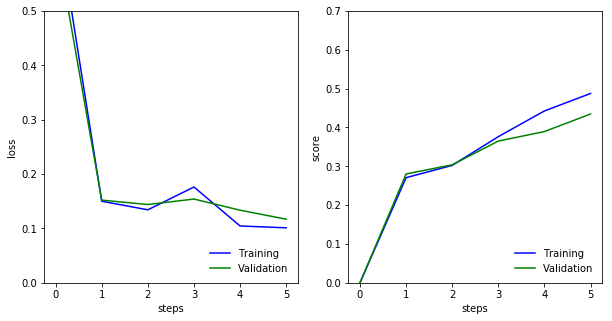

In [28]:
# Show intermediate losses and scores during the training session.
mn = 'nn0_512_512_3' 
## default is 256 x 256 x 3
#mn = 'nn0_256_256_3' 
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(mn)
sess.close()
train_loss = u_net.params['train_loss']
valid_loss = u_net.params['valid_loss']
train_score = u_net.params['train_score']
valid_score = u_net.params['valid_score']

print('final train/valid loss = {:.4f}/{:.4f}'.format(train_loss[-1], valid_loss[-1]))
print('final train/valid score = {:.4f}/{:.4f}'.format(train_score[-1], valid_score[-1]))
plt.figure(figsize=(10, 5));
plt.subplot(1,2,1)
plt.plot(np.arange(0,len(train_loss)), train_loss,'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss)), valid_loss,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 0.5, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('steps');

plt.subplot(1,2,2);
plt.plot(np.arange(0,len(train_score)), train_score,'-b', label='Training')
plt.plot(np.arange(0,len(valid_score)), valid_score,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 0.7, ymin = 0.0)
plt.ylabel('score')
plt.xlabel('steps');



### 7. Validate the Neural Network

In [29]:
# Split training and validation data in the same way 
# as was done for training the neural network.
if True:
    cv_num = 10 
    kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=SEED)
    for i,(train_index, valid_index) in enumerate(kfold.split(x_train)):
        if i==1:
            x_trn = x_train[train_index]
            y_trn = y_train[train_index]
            x_vld = x_train[valid_index]
            y_vld = y_train[valid_index]

INFO:tensorflow:Restoring parameters from nn0_512_512_3
Parameters of the loaded neural network
	nn_name = nn0_512_512_3, epoch = 4.03, mb_size = 16
	input_shape = (512, 512, 3), output_shape = (512, 512, 1)
	learn_rate = 0.0007500000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 1, learn_rate_alpha = 0.25

            index  valid_index  valid_score
count  67.000000    67.000000    67.000000
mean   33.000000   337.223881     0.424796
std    19.485037   197.944882     0.227595
min     0.000000     2.000000     0.000000
25%    16.500000   156.000000     0.230037
50%    33.000000   357.000000     0.445314
75%    49.500000   523.500000     0.612932
max    66.000000   668.000000     0.854286

     index  valid_index  valid_score
18   18.0        176.0     0.000000
64   64.0        662.0     0.013226
52   52.0        555.0     0.066484
43   43.0        411.0     0.068531
36   36.0        365.0     0.072622


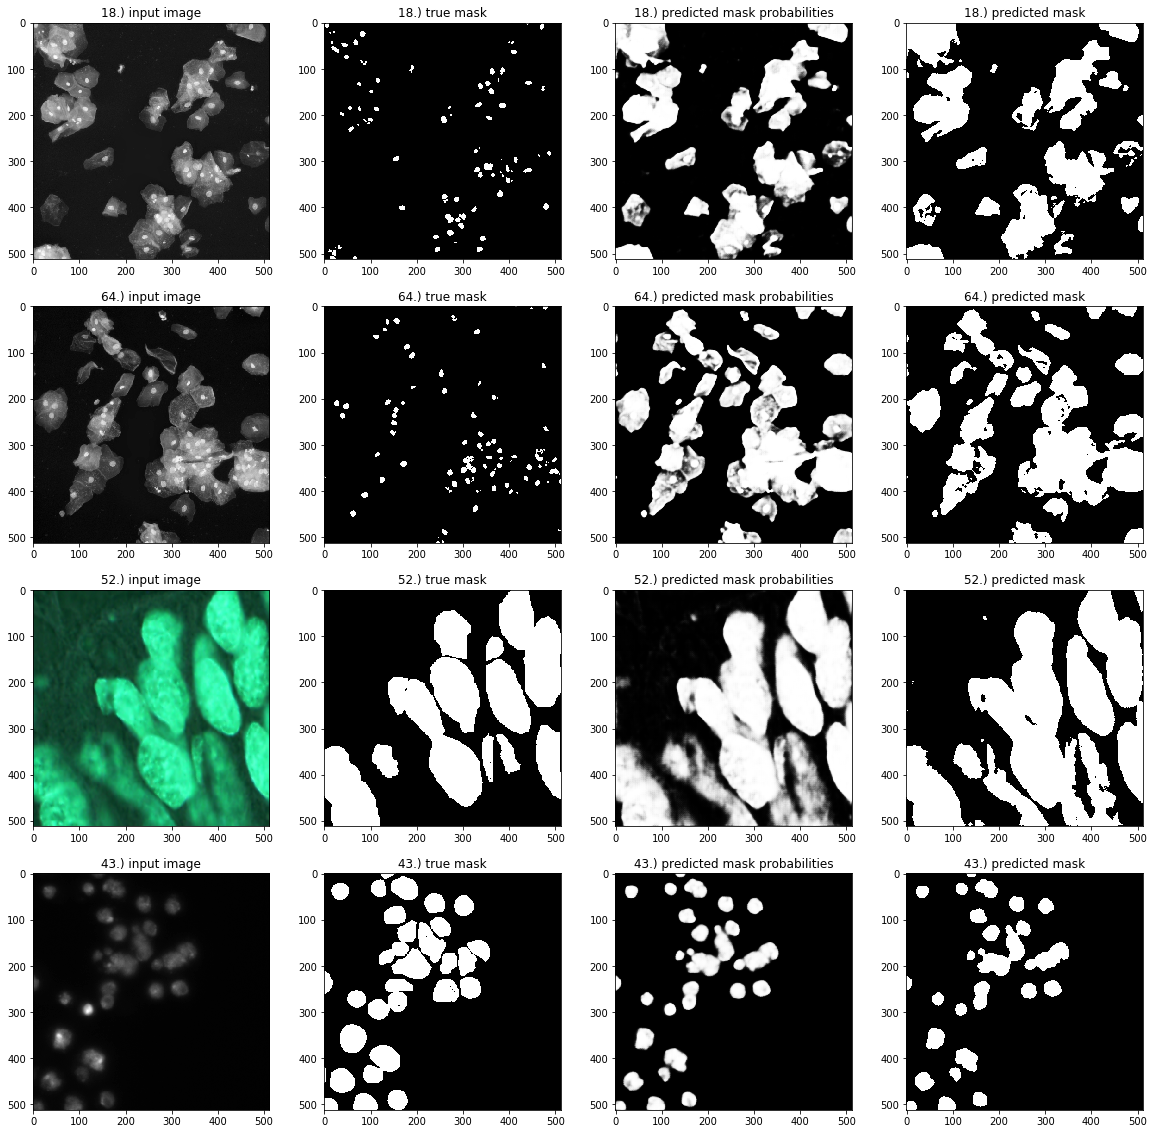

In [30]:
# Summary of scores for training and validations sets. Note that the score is
# better than the true score, since overlapping/touching nuclei can not be
# separately identified in this version.  
mn = 'nn0_512_512_3'
#mn = 'nn0_256_256_3'
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(mn)

if False:
    # Overall score on train set.
    y_train_pred = trsf_proba_to_binary(u_net.get_prediction(sess, x_trn))
    train_score = get_score(y_trn, y_train_pred)
    tmp = np.concatenate([train_index.reshape(-1,1), train_score.reshape(-1,1)], axis=1)
    train_score_df = pd.DataFrame(tmp, columns=(['train_index','train_score']))
    print(train_score_df.describe())
    print('')
    print(train_score_df.sort_values(by='train_score', ascending=True).head())

if True:
    # Overall score on validation set.
    y_valid_pred_proba = u_net.get_prediction(sess, x_vld)
    y_valid_pred = trsf_proba_to_binary(y_valid_pred_proba)
    valid_score = get_score(y_vld, y_valid_pred)
    tmp = np.concatenate([np.arange(len(valid_index)).reshape(-1,1),
                          valid_index.reshape(-1,1),
                          valid_score.reshape(-1,1)], axis=1)
    valid_score_df = pd.DataFrame(tmp, columns=(['index', 'valid_index','valid_score']))
    print('\n', valid_score_df.describe())
    print('\n', valid_score_df.sort_values(by='valid_score', ascending=True).head())

    # Plot the worst 4 predictions.
    fig, axs = plt.subplots(4,4,figsize=(20,20))
    list_ = valid_score_df.sort_values(by='valid_score', ascending=True)[:4]['index'].values.astype(np.int)
    #list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
    for i,n in enumerate(list_):
        img, img_type = imshow_args(x_vld[n])
        axs[i,0].imshow(img, img_type)
        axs[i,0].set_title('{}.) input image'.format(n))
        axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
        axs[i,1].set_title('{}.) true mask'.format(n))
        axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
        axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
        axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
        axs[i,3].set_title('{}.) predicted mask'.format(n));

sess.close()

Note the session close above

In [32]:
# Tune minimal object size for prediction 
if True:
    mn = 'nn0_512_512_3'
    #mn = 'nn0_256_256_3'
    u_net = NeuralNetwork()
    sess = u_net.load_session_from_file(mn)
    y_valid_pred_proba = u_net.get_prediction(sess, x_vld)
    y_valid_pred = trsf_proba_to_binary(y_valid_pred_proba)
    sess.close()        
    
    tmp = min_object_size
    min_object_sizes = [1,3,5,7,9,20,30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500]
    #min_object_sizes = np.arange(65,76,1)
    for mos in min_object_sizes:
        min_object_size = mos
        valid_score = get_score(y_vld, y_valid_pred)
        print('min_object_size = {}: valid_score min/mean/std/max = {:.3f}/{:.3f}/{:.3f}/{:.3f}'.format(mos, 
                np.min(valid_score), np.mean(valid_score), np.std(valid_score), np.max(valid_score)))
    min_object_size = tmp

INFO:tensorflow:Restoring parameters from nn0_512_512_3
Parameters of the loaded neural network
	nn_name = nn0_512_512_3, epoch = 4.03, mb_size = 16
	input_shape = (512, 512, 3), output_shape = (512, 512, 1)
	learn_rate = 0.0007500000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 1, learn_rate_alpha = 0.25
min_object_size = 1: valid_score min/mean/std/max = 0.000/0.425/0.226/0.854
min_object_size = 3: valid_score min/mean/std/max = 0.000/0.434/0.223/0.854
min_object_size = 5: valid_score min/mean/std/max = 0.000/0.436/0.223/0.854
min_object_size = 7: valid_score min/mean/std/max = 0.000/0.437/0.222/0.854
min_object_size = 9: valid_score min/mean/std/max = 0.000/0.438/0.222/0.854
min_object_size = 20: valid_score min/mean/std/max = 0.000/0.444/0.224/0.854
min_object_size = 30: valid_score min/mean/std/max = 0.000/0.447/0.225/0.854
min_object_size = 40: valid_score min/mean/std/max = 0.000/0.452/0.227/0.854
min_object_size = 50: valid_score min/

INFO:tensorflow:Restoring parameters from nn0_512_512_3
Parameters of the loaded neural network
	nn_name = nn0_512_512_3, epoch = 4.03, mb_size = 16
	input_shape = (512, 512, 3), output_shape = (512, 512, 1)
	learn_rate = 0.0007500000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 1, learn_rate_alpha = 0.25
Final score: 0.00466424368294
   threshold  precision   tp    fp    fn
0       0.50   0.018692  2.0  42.0  63.0
1       0.55   0.018692  2.0  42.0  63.0
2       0.60   0.009259  1.0  43.0  64.0
3       0.65   0.000000  0.0  44.0  65.0
4       0.70   0.000000  0.0  44.0  65.0
5       0.75   0.000000  0.0  44.0  65.0
6       0.80   0.000000  0.0  44.0  65.0
7       0.85   0.000000  0.0  44.0  65.0
8       0.90   0.000000  0.0  44.0  65.0
9       0.95   0.000000  0.0  44.0  65.0


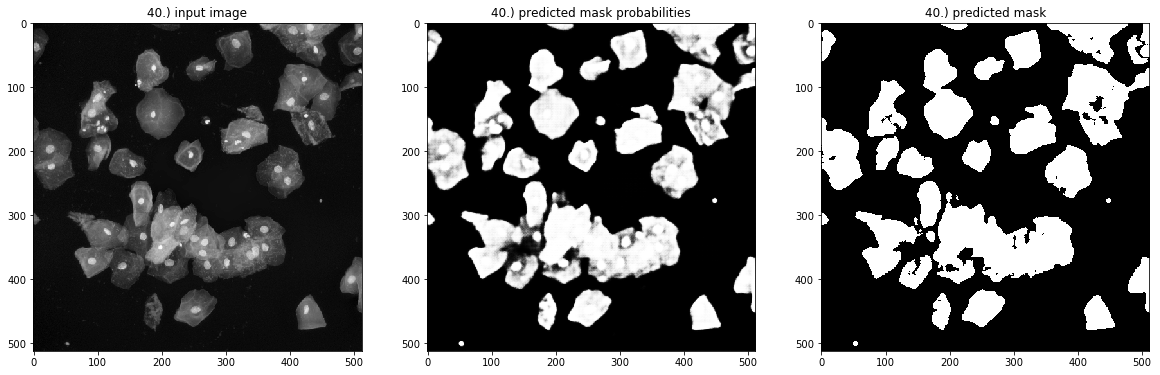

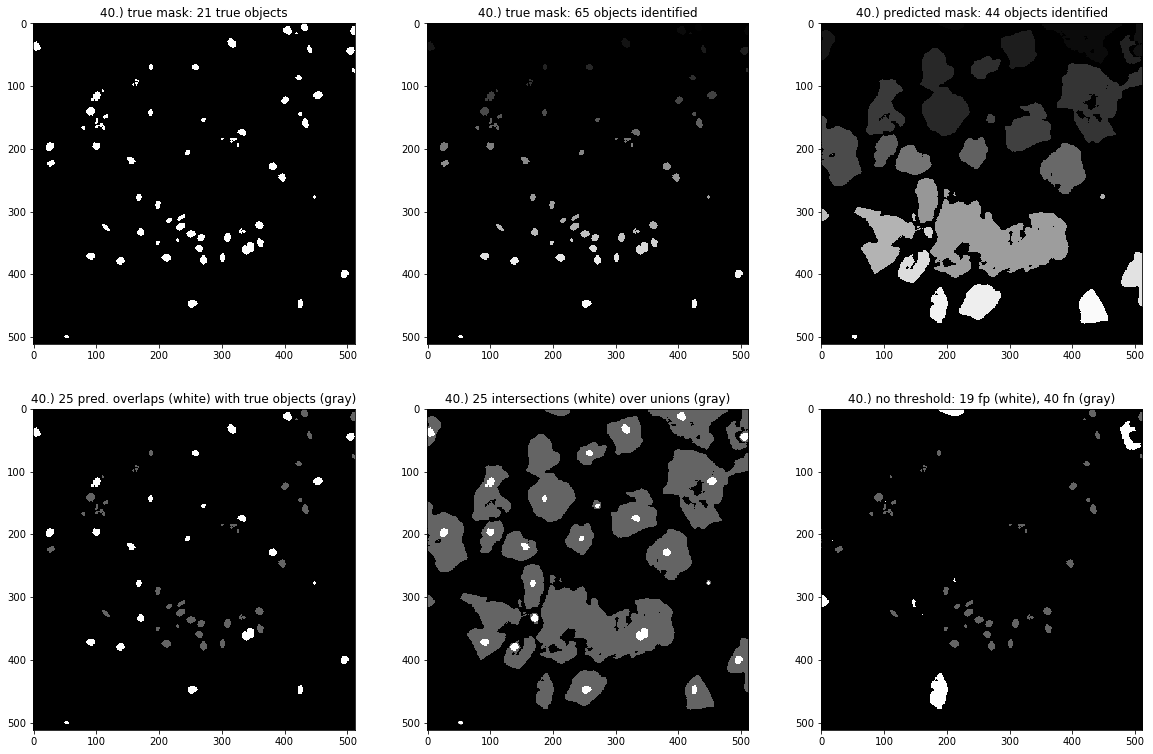

In [105]:
# Check one sample prediction in more detail.
mn = 'nn0_512_512_3'
#mn = 'nn0_256_256_3'
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(mn)
n = 40 # np.random.randint(len(x_train))
x_true = x_vld[n]
y_true = y_vld[n,:,:,0]
y_pred_proba = (u_net.get_prediction(sess, np.expand_dims(x_true, axis=0)))[0,:,:,0]
y_pred = trsf_proba_to_binary(y_pred_proba)
sess.close()

fig, axs = plt.subplots(1,3,figsize=(20,13))
img, img_type = imshow_args(x_true)
axs[0].imshow(img, img_type)
axs[0].set_title('{}.) input image'.format(n))
axs[1].imshow(y_pred_proba, cmap='gray') 
axs[1].set_title('{}.) predicted mask probabilities'.format(n));
axs[2].imshow(y_pred, cmap='gray') 
axs[2].set_title('{}.) predicted mask'.format(n));
plot_score_summary(y_true, y_pred)

### 8. Make Test Prediction

In [106]:
# Collection of methods for run length encoding. 
# For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included 
# in the mask. The pixels are one-indexed and numbered from top to bottom, 
# then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

def rle_of_binary(x):
    """ Run length encoding of a binary 2D array. """
    dots = np.where(x.T.flatten() == 1)[0] # indices from top to down
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def mask_to_rle(mask, cutoff=.5, min_object_size=1.):
    """ Return run length encoding of mask. """
    # segment image and label different objects
    lab_mask = skimage.morphology.label(mask > cutoff)
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
        
    # Loop over each object excluding the background labeled by 0.
    for i in range(1, lab_mask.max() + 1):
        yield rle_of_binary(lab_mask == i)
        
def rle_to_mask(rle, img_shape):
    ''' Return mask from run length encoding.'''
    mask_rec = np.zeros(img_shape).flatten()
    for n in range(len(rle)):
        for i in range(0,len(rle[n]),2):
            for j in range(rle[n][i+1]): 
                mask_rec[rle[n][i]-1+j] = 1
    return mask_rec.reshape(img_shape[1], img_shape[0]).T
        

In [107]:
# Load neural network, make prediction for test masks, resize predicted
# masks to original image size and apply run length encoding for the
# submission file. 

# Load neural network and make prediction for masks.
nn_name = ['nn0_512_512_3']
#nn_name = ['nn0_256_256_3']

# Soft voting majority.
for i,mn in enumerate(nn_name):
    u_net = NeuralNetwork()
    sess = u_net.load_session_from_file(mn)
    if i==0: 
        y_test_pred_proba = u_net.get_prediction(sess, x_test)/len(nn_name)
        print("Mask probability shape: {}".format(y_test_pred_proba.shape))
    else:
        y_test_pred_proba += u_net.get_prediction(sess, x_test)/len(nn_name)
    sess.close()

y_test_pred = trsf_proba_to_binary(y_test_pred_proba)
print('y_test_pred.shape = {}'.format(y_test_pred.shape))

# Resize predicted masks to original image size.
y_test_pred_original_size = []
for i in range(len(y_test_pred)):
    res_mask = trsf_proba_to_binary(skimage.transform.resize(np.squeeze(y_test_pred[i]),
        (test_df.loc[i,'img_height'], test_df.loc[i,'img_width']), 
        mode='constant', preserve_range=True))
    y_test_pred_original_size.append(res_mask)
y_test_pred_original_size = np.array(y_test_pred_original_size)

print('y_test_pred_original_size.shape = {}'.format(y_test_pred_original_size.shape))
   
# Run length encoding of predicted test masks.
test_pred_rle = []
test_pred_ids = []
print(test_df.head(5))
for n, id_ in enumerate(test_df['img_id']):
    #min_object_size = 20*test_df.loc[n,'img_height']*test_df.loc[n,'img_width']/(256*256)
    print("hight: {}, width: {}".format(test_df.loc[n,'img_height'],test_df.loc[n,'img_width']))
    min_object_size = 20*test_df.loc[n,'img_height']*test_df.loc[n,'img_width']/(512*512)
    rle = list(mask_to_rle(y_test_pred_original_size[n], min_object_size=min_object_size))
    print("Mask shape: {}".format(y_test_pred_original_size[n].shape))
    test_pred_rle.extend(rle)
    test_pred_ids.extend([id_]*len(rle))
    break


print('test_pred_ids.shape = {}'.format(np.array(test_pred_ids).shape))
print('test_pred_rle.shape = {}'.format(np.array(test_pred_rle).shape))

INFO:tensorflow:Restoring parameters from nn0_512_512_3
Parameters of the loaded neural network
	nn_name = nn0_512_512_3, epoch = 4.03, mb_size = 16
	input_shape = (512, 512, 3), output_shape = (512, 512, 1)
	learn_rate = 0.0007500000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 1, learn_rate_alpha = 0.25
Mask probability shape: (65, 512, 512, 1)
y_test_pred.shape = (65, 512, 512, 1)
y_test_pred_original_size.shape = (65,)
                                              img_id  img_height  img_width  \
0  336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...         519        253   
1  ca20076870e8fb604e61802605a9ac45419c82dd3e2340...         519        161   
2  519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...         256        256   
3  d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...         519        162   
4  1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...         519        162   

   img_ratio  num_channels                            

65
Run length encoding: 65536 matches, 0 misses


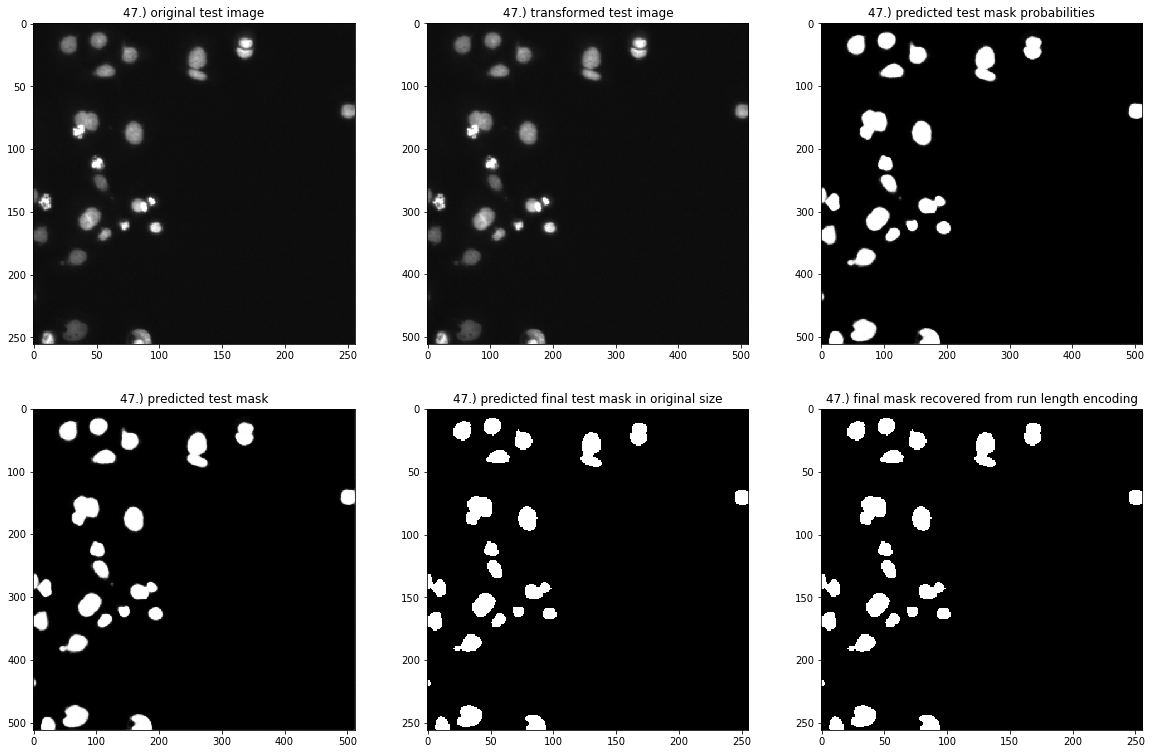

In [108]:
# Inspect a test prediction and check run length encoding.
n = 47 # np.random.randint(len(x_test))
print(len(y_test_pred_original_size))
mask = y_test_pred_original_size[n]
rle = list(mask_to_rle(mask))
mask_rec = rle_to_mask(rle, mask.shape)
print('Run length encoding: {} matches, {} misses'.format(
    (mask_rec == mask).sum(),(mask_rec != mask).sum()))

fig, axs = plt.subplots(2,3,figsize=(20,13))
axs[0,0].imshow(read_image(test_df['image_path'].loc[n]))
axs[0,0].set_title('{}.) original test image'.format(n))
img, img_type = imshow_args(x_test[n])
axs[0,1].imshow(img, img_type)
axs[0,1].set_title('{}.) transformed test image'.format(n))
axs[0,2].imshow(y_test_pred_proba[n][:,:,0], cm.gray) 
axs[0,2].set_title('{}.) predicted test mask probabilities'.format(n));
axs[1,0].imshow(y_test_pred_proba[n][:,:,0], cm.gray) 
axs[1,0].set_title('{}.) predicted test mask'.format(n));
axs[1,1].imshow(y_test_pred_original_size[n], cm.gray);
axs[1,1].set_title('{}.) predicted final test mask in original size'.format(n));
axs[1,2].imshow(mask_rec[:,:], cm.gray);
axs[1,2].set_title('{}.) final mask recovered from run length encoding'.format(n));

### 9. Submission output file

In [109]:
# Create submission file
sub = pd.DataFrame()
sub['ImageId'] = test_pred_ids
sub['EncodedPixels'] = pd.Series(test_pred_rle).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)
sub.head()


,ImageId,EncodedPixels
0,336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...,22842 6 23360 9 23878 11 24396 12 24913 16 254...
1,336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...,108478 5 108995 9 109514 10 110032 12 110551 1...
2,336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...,44664 6 45181 10 45699 13 46218 14 46737 15 47...
3,336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...,70640 2 71156 10 71674 13 72191 16 72708 20 73...
4,336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...,33 6 551 8 1071 6
